In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import seaborn as sn
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import auc
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score


In [2]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point


def ROC(label, y_prob):
    fpr, tpr, thresholds = roc_curve(label, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point
    

In [3]:
# Data Loading
f = r'C:\Users\User\VSCODE\CDSS\source\Clean\CDSS_0628.xlsx'

CDSS = pd.read_excel(f, dtype={'病歷號碼':'str'})
# m = CDSS[CDSS.openTime==CDSS.minTime]

In [4]:
# Filter Fault Time
CDSS['sendTime'] = pd.to_datetime(CDSS['sendTime'])
CDSS = CDSS[(CDSS['sendTime'] < pd.to_datetime('2022-03-07 00:00')) | (CDSS['sendTime'] > pd.to_datetime('2022-03-21 23:59'))]

CDSS = CDSS[['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', 'Age', '抗藥性菌株', 'examTime',
         'reportTime', 'openTime', '菌株', 'PredValue', 'sendTime', 'Group_Strain', 'PredLevel', 'Resist_bool']].drop_duplicates() 

# TH = 60
CDSS['TH60'] = np.where(CDSS['PredValue']>=60, True, False)


# TH = 85 (Recommend)
# CDSS['TH85'] = np.where(CDSS['PredValue']>=85, True, False)

In [52]:
# CDSS.to_excel(r'C:\Users\User\VSCode\CDSS_0420.xlsx')

In [5]:
CDSS.Group_Strain.value_counts()

Enterococcus faecium       270
Klebsiella pneumoniae      264
Escherichia coli           254
Pseudomonas aeruginosa     239
Acinetobacter baumannii    188
Staphylococcus aureus      170
Morganella morganii         19
Enterobacter cloacae        18
Name: Group_Strain, dtype: int64

In [6]:
# Strain 
SA = CDSS[CDSS.Group_Strain=='Staphylococcus aureus'].reset_index(drop=True)
EF = CDSS[CDSS.Group_Strain=='Enterococcus faecium'].reset_index(drop=True)
KP = CDSS[CDSS.Group_Strain=='Klebsiella pneumoniae'].reset_index(drop=True)
EC = CDSS[CDSS.Group_Strain=='Escherichia coli'].reset_index(drop=True)
PA = CDSS[CDSS.Group_Strain=='Pseudomonas aeruginosa'].reset_index(drop=True)
AB = CDSS[CDSS.Group_Strain=='Acinetobacter baumannii'].reset_index(drop=True)
MM = CDSS[CDSS.Group_Strain=='Morganella morganii'].reset_index(drop=True)
ECL = CDSS[CDSS.Group_Strain=='Enterobacter cloacae'].reset_index(drop=True)
# Resist
SA['Resist'] = np.where(SA['Resist_bool']==True, 'MRSA', 'MSSA')
KP['Resist'] = np.where(KP['Resist_bool']==True, 'CRKP', 'CSKP')
# SA['Resist_bool'] = np.where(SA['Resist']=='MRSA', 1, 0)
# SA.rename({'年齡':'Age', '預測值':'PredValue'}, axis=1, inplace=True)

# # scatter plot

# plt.figure(figsize=(16, 9))
# sn.set(font_scale = 1.5)
# plt.title('Staphylococcus aureus (Jan-Mar 2022)', fontsize = 25)
# # Acinetobacter baumannii   AB  CRAB    CSAB
# # Staphylococcus aureus     SA	MRSA	MSSA
# # Escherichia coli          EC	CREC	CSEC
# # Pseudomonas aeruginosa    PA	CRPA	CSPA
# # Klebsiella pneumoniae     KP	CRKP	CSKP
# # Morganella morganii       MM	CRMM	CSMM
# # Enterococcus faecium      EF	VRE	VSE

# ax = sn.scatterplot(data=SA, x="PredValue", y="Age", hue="Resist")
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# # plt.legend(loc='upper right')
# # sn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1), frameon=True)

# plt.show()


# distribution
print('Strain: Staphylococcus aureus (Jan-Mar 2022)')
print('Amount:', SA['病歷號碼'].count())
print('Patient:', SA['病歷號碼'].drop_duplicates().count())
print()
print(SA.groupby('PredLevel')['Resist'].value_counts().sort_index())
SA.groupby('PredLevel')['PredValue'].describe()



Strain: Staphylococcus aureus (Jan-Mar 2022)
Amount: 170
Patient: 116

PredLevel  Resist
0~20%      MRSA      14
           MSSA      47
21~40%     MRSA       5
           MSSA       5
41~60%     MRSA       3
           MSSA       1
61~80%     MRSA       5
           MSSA       4
81~100%    MRSA      75
           MSSA      11
Name: Resist, dtype: int64


,count,mean,std,min,25%,50%,75%,max
PredLevel,,,,,,,,
0~20%,61.0,8.737705,4.238324,0.0,10.00,10.0,10.0,19.0
21~40%,10.0,29.900000,5.989806,22.0,24.75,29.0,35.0,40.0
41~60%,4.0,53.500000,6.855655,45.0,49.50,54.5,58.5,60.0
61~80%,9.0,73.000000,6.480741,64.0,67.00,75.0,79.0,80.0
81~100%,86.0,98.500000,2.755743,85.0,99.00,99.0,100.0,100.0


In [7]:
SA['TH85'] = np.where(SA['PredValue']>=85, True, False)

In [8]:
# SA.to_excel(r'C:\Users\User\VSCode\CDSS_SA.xlsx')

Threshold

<function matplotlib.pyplot.show(close=None, block=None)>

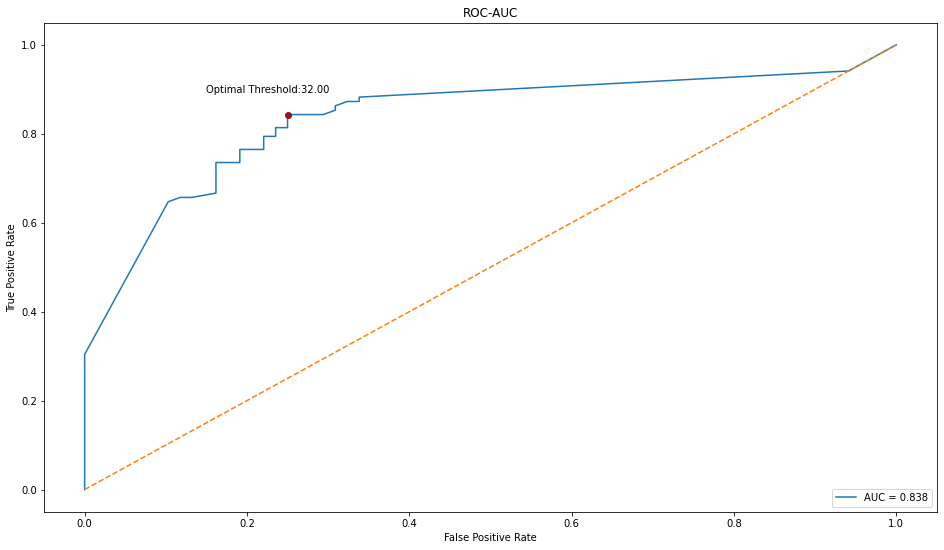

In [8]:
# Create the ROC curve
# fpr, tpr, thresholds = roc_curve(SA['Resist_bool'], SA.PredValue)

fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(SA['Resist_bool'], SA.PredValue)

plt.figure(figsize=(16, 9))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker="o", color="#981220")
plt.text(optimal_point[0]-0.1, optimal_point[1]+0.05, f'Optimal Threshold:{optimal_th:.2f}')
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show

In [12]:
GGGGG = pd.DataFrame(SA.PredValue.value_counts())

Best Threshold: 32 with G-Mean: 0.7952
FPR: 0.25, TPR: 0.8431


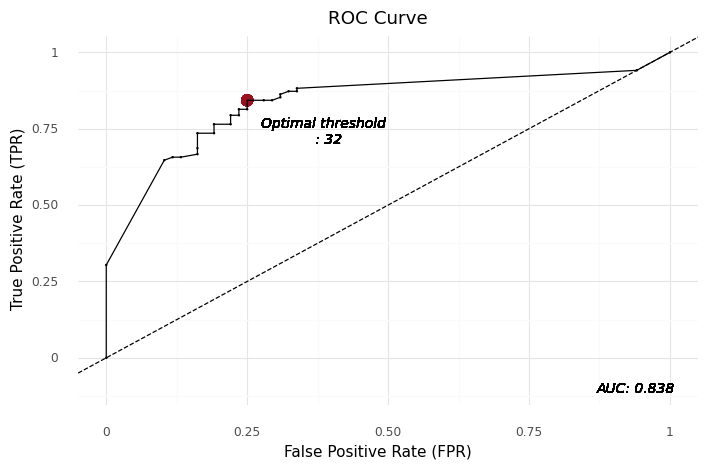

<ggplot: (180588622084)>

In [21]:
# Import module for data visualization
from plotnine import *
import plotnine

# Create the ROC curve
fpr, tpr, thresholds = roc_curve(SA['Resist_bool'], SA.PredValue)

# Plot the ROC curve
df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})


# Calculate the G-mean
gmean = np.sqrt(tpr * (1 - fpr))

# Find the optimal threshold
index = np.argmax(gmean)
thresholdOpt = round(thresholds[index], ndigits = 4)
gmeanOpt = round(gmean[index], ndigits = 4)
fprOpt = round(fpr[index], ndigits = 4)
tprOpt = round(tpr[index], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

# Create data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_fpr_tpr)+
    geom_point(aes(x = 'FPR',
                   y = 'TPR'),
               size = 0.001)+
    # Best threshold
    geom_point(aes(x = fprOpt,
                   y = tprOpt),
               color = '#981220',
               size = 4)+
    geom_abline(color='black',
                linetype="dashed")+
    geom_line(aes(x = 'FPR',
                  y = 'TPR'))+
    geom_text(aes(x = fprOpt,
                  y = tprOpt),
              label = 'Optimal threshold \n : {}'.format(thresholdOpt),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    geom_text(aes(x = 0.8,
                  y = 0),
              label = 'AUC: {}'.format(round(roc_auc, ndigits = 3)),
              nudge_x = 0.14,
              nudge_y = -0.10,
              size = 10,
              fontstyle = 'italic')+
    labs(title = 'ROC Curve')+
    xlab('False Positive Rate (FPR)')+
    ylab('True Positive Rate (TPR)')+
    theme_minimal()
)

Confusion Matrix

Threshold  MRSA  MSSA
Actual               
MRSA         81    21
MSSA         15    53


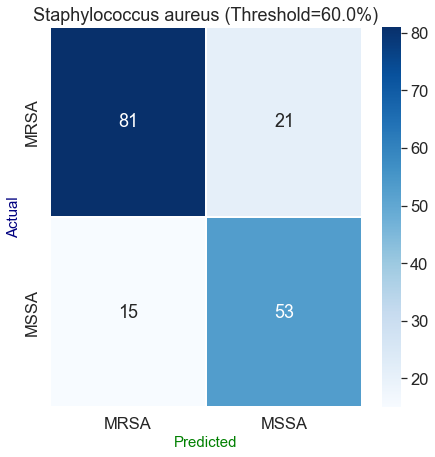

In [74]:
# confusion matrix
SA['Threshold'] = np.where(SA.PredValue >= 60, 'MRSA', 'MSSA')
# SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
confusion_matrix_SA = pd.crosstab(SA['Resist'], SA['Threshold'], rownames=['Actual'], colnames=['Threshold'])
print (confusion_matrix_SA)


plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5, cmap='Blues')
plt.title(f'Staphylococcus aureus (Threshold={60:.1f}%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

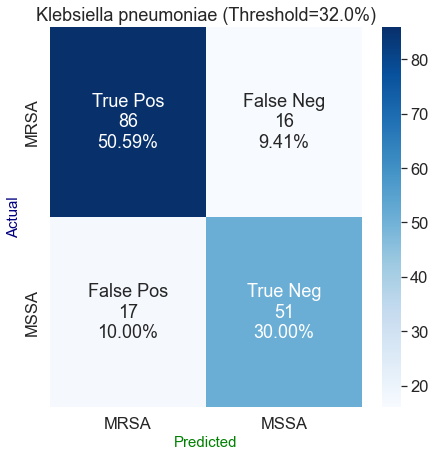

In [65]:
plt.figure(figsize=(7,7))
sn.set(font_scale = 1.5)
group_names = ['True Pos','False Neg','False Pos','True Neg'] 
# labels = np.asarray(labels).reshape(2,2)
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix_SA.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix_SA.to_numpy().flatten()/np.sum(confusion_matrix_SA.to_numpy())]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(confusion_matrix_SA, annot=labels, fmt='', cmap='Blues')
plt.title(f'Staphylococcus aureus (Threshold={optimal_th:.1f}%)', fontsize = 18)
plt.xlabel('Predicted', fontsize = 15, color='green')
plt.ylabel('Actual', fontsize = 15, color='navy')
plt.show()

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import seaborn as sn
import matplotlib.pyplot as plt

In [4]:
file = r'C:\Users\User\VSCODE\CDSS\source\Clean\SA無菌部位用藥_0707.xlsx'
SA_culture = pd.read_excel(file, dtype={'病歷號碼':'str'})

In [5]:
SA_culture.columns

Index(['病歷號碼', '住院號', '申請編號', 'AntiMRSA_Exam_B', '採檢日', 'AntiMRSA_Exam_A',
       'sendTime', 'AntiMRSA_MDRO_A', '報告日', 'AntiMRSA_Report_A', 'MRSA',
       '檢體'],
      dtype='object')

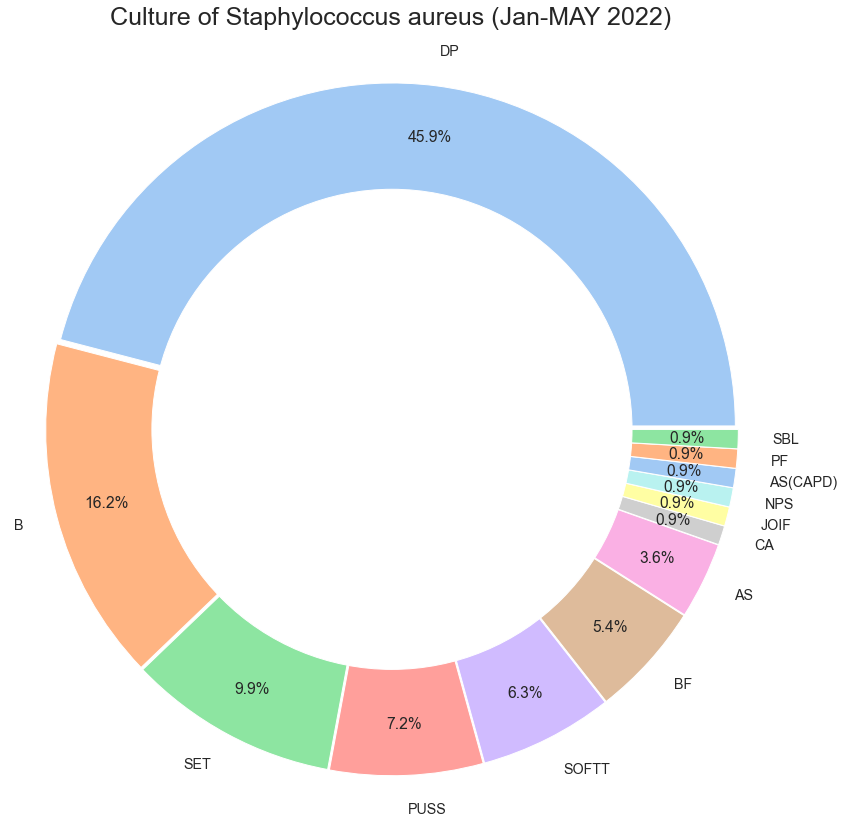

In [31]:
pieData = SA_culture['檢體'].value_counts()
label = pieData.index

colors = sn.color_palette('pastel')

#explsion
explode = (0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01)

#create pie chart
sn.set(font_scale = 1.3)
plt.figure(figsize=(12,12))
plt.pie(pieData, labels = label, autopct='%.1f%%', colors=colors, pctdistance=0.85, explode = explode)
plt.title('Culture of Staphylococcus aureus (Jan-MAY 2022)', fontsize = 25)


#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

In [14]:
# confusion matrix

for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    for t in range(10, 100, 10):
        s['Threshold'] = np.where(s.PredValue >= t, True, False)
        # SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
        confusion_matrix = pd.crosstab(s['Resist_bool'], s['Threshold'], rownames=['Actual'], colnames=['Threshold'])
        # print (confusion_matrix)
        
        # plt.figure(figsize=(7,7))
        # sn.set(font_scale = 1.5)
        # sn.heatmap(confusion_matrix_SA, annot=True, fmt='d', linewidths=1.5)
        # plt.title(f'{s.Group_Strain[0]} (Threshold={t:.1f}%)', fontsize = 18)
        # plt.xlabel('Predicted', fontsize = 15, color='green')
        # plt.ylabel('Actual', fontsize = 15, color='navy')
        
        # plt.savefig(r"C:\Users\User\VSCode\LULU\ConfusionMatric\\{}.png".format(s.Group_Strain[0] + str(t)))
        
        # plt.figure(figsize=(7,7))
        # sn.set(font_scale = 1.5)
        # group_names = ['True Pos','False Neg','False Pos','True Neg'] 
        # # labels = np.asarray(labels).reshape(2,2)
        # group_counts = ["{0:0.0f}".format(value) for value in
        #                 confusion_matrix_SA.to_numpy().flatten()]
        # group_percentages = ["{0:.2%}".format(value) for value in
        #                     confusion_matrix_SA.to_numpy().flatten()/np.sum(confusion_matrix_SA.to_numpy())]
        # labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
        #         zip(group_names,group_counts,group_percentages)]
        # labels = np.asarray(labels).reshape(2,2)
        # sn.heatmap(confusion_matrix_SA, annot=labels, fmt='', cmap='Blues')
        # plt.title(f'{s.Group_Strain[0]} (Threshold={t:.1f}%)', fontsize = 18)
        # plt.xlabel('Predicted', fontsize = 15, color='green')
        # plt.ylabel('Actual', fontsize = 15, color='navy')
        # plt.show()

In [15]:
# sensitive = {'Strain':[], 'Threshold':[], 'Value':[]}
Strain = []
Threshold = []
Sensitivity = []
Specificity = []
Positive_predictive_value = []
Negative_predictive_value = []

for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    for t in range(0, 101):
        s['Threshold'] = np.where(s.PredValue >= t, True, False)
        # SA['Predicted'] = np.where(SA['PredLevel'] != '81~100%', 'MSSA', 'MRSA')
        
        Strain.append(s.Group_Strain[0])
        Threshold.append(t)
        Sensitivity.append(s[(s['Threshold']==True) & (s['Resist_bool']==True)]['Threshold'].count() / s[s['Resist_bool']==True]['Resist_bool'].count())
        Specificity.append(s[(s['Threshold']==False) & (s['Resist_bool']==False)]['Threshold'].count() / s[s['Resist_bool']==False]['Resist_bool'].count())
        Positive_predictive_value.append(s[(s['Threshold']==True) & (s['Resist_bool']==True)]['Threshold'].count() / s[s['Threshold']==True]['Resist_bool'].count())
        Negative_predictive_value.append(s[(s['Threshold']==False) & (s['Resist_bool']==False)]['Threshold'].count() / s[s['Threshold']==False]['Resist_bool'].count())
        
        # print (f"{s.Group_Strain[0]} (Threshold={t:.1f}%")
        # print(s[s['Threshold']==True & (s['Resist_bool']==True)]['Threshold'].count() / s[s['Resist_bool']==True]['Resist_bool'].count())

C:\Users\User\AppData\Local\Temp\ipykernel_9668\2662014543.py:19: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\User\AppData\Local\Temp\ipykernel_9668\2662014543.py:18: RuntimeWarning: invalid value encountered in longlong_scalars


In [17]:
df = pd.DataFrame((zip(Strain, Threshold, Sensitivity, Specificity, Positive_predictive_value, Negative_predictive_value)), 
                  columns = ['Strain', 'Threshold', 'Sensitivity', 'Specificity', 'Positive_predictive_value', 'Negative_predictive_value'])
# df.to_excel(r'C:\Users\User\VSCode\CDSS_Confusion_Matrix_0415.xlsx')

In [32]:
recommend = {'Strain':[], 'Threshold':[], 'Roc_Auc':[]}
for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(s['Resist_bool'], s.PredValue)
    
    recommend['Strain'].append(s.Group_Strain[0])
    recommend['Threshold'].append(optimal_th)
    recommend['Roc_Auc'].append(round(roc_auc, 2))
    print(s.Group_Strain[0], ': ', optimal_th, ', Roc: ', round(roc_auc, 2))
    # print(optimal_th)

Staphylococcus aureus :  85 , Roc:  0.83
Enterococcus faecium :  100 , Roc:  0.64
Klebsiella pneumoniae :  64 , Roc:  0.61
Escherichia coli :  10 , Roc:  0.55
Pseudomonas aeruginosa :  14 , Roc:  0.47
Acinetobacter baumannii :  88 , Roc:  0.34
Morganella morganii :  11 , Roc:  0.5
Enterobacter cloacae :  11 , Roc:  0.44


In [27]:
pd.DataFrame(recommend)

,Strain,Threshold,Roc_Auc
0,Staphylococcus aureus,85,0.83
1,Enterococcus faecium,100,0.64
2,Klebsiella pneumoniae,64,0.61
3,Escherichia coli,10,0.55
4,Pseudomonas aeruginosa,14,0.47
5,Acinetobacter baumannii,88,0.34
6,Morganella morganii,11,0.50
7,Enterobacter cloacae,11,0.44


In [17]:
A = 0
for s in [SA, EF, KP, EC, PA, AB, MM, ECL]:
    A = A + s['病歷號碼'].drop_duplicates().count() 
print(A)

589


In [20]:
SA['Resist'] = np.where(SA['Resist_bool']==True, 1, 0)
SA['Non_Resist'] = np.where(SA['Resist_bool']==False, 1, 0)

condition_1 = [(SA['PredValue'] <= 10), (SA['PredValue'] > 10)&(SA['PredValue'] <= 20), 
             (SA['PredValue'] > 20)&(SA['PredValue'] <= 30), (SA['PredValue'] > 30)&(SA['PredValue'] <= 40),
             (SA['PredValue'] > 40)&(SA['PredValue'] <= 50), (SA['PredValue'] > 50)&(SA['PredValue'] <= 60), 
             (SA['PredValue'] > 60)&(SA['PredValue'] <= 70), (SA['PredValue'] > 70)&(SA['PredValue'] <= 80),
             (SA['PredValue'] > 80)&(SA['PredValue'] <= 90), (SA['PredValue'] > 90)&(SA['PredValue'] <= 100)]

value_1 = ['0~10%', '10~20%', '20~30%', '30~40%', '40~50%', '50~60%', '60~70%', '70~80%',
           '80~90%', '90~100%']
SA['PredLevel'] = np.select(condition_1, value_1) 

BBC_SA = SA.groupby('PredValue')[['Resist', 'Non_Resist']].sum()
# BBC_SA.index = ['0~5%', '5~10%', '10~15%', '15~20%', '20~25%', '25~30%', '30~35%', '35~40%',
#                 '40~45%', '45~50%', '50~55%', '55~60%', '60~65%', '65~70%', '70~75%', '75~80%',
#                 '80~85%', '85~90%', '90~95%', '95~100%']

KP['Resist'] = np.where(KP['Resist_bool']==True, 1, 0)
KP['Non_Resist'] = np.where(KP['Resist_bool']==False, 1, 0)
BBC_KP = KP.groupby('PredValue')[['Resist', 'Non_Resist']].sum()

In [21]:
BBC_SA = BBC_SA.sort_index(ascending=False)
BBC_KP = BBC_KP.sort_index(ascending=False)


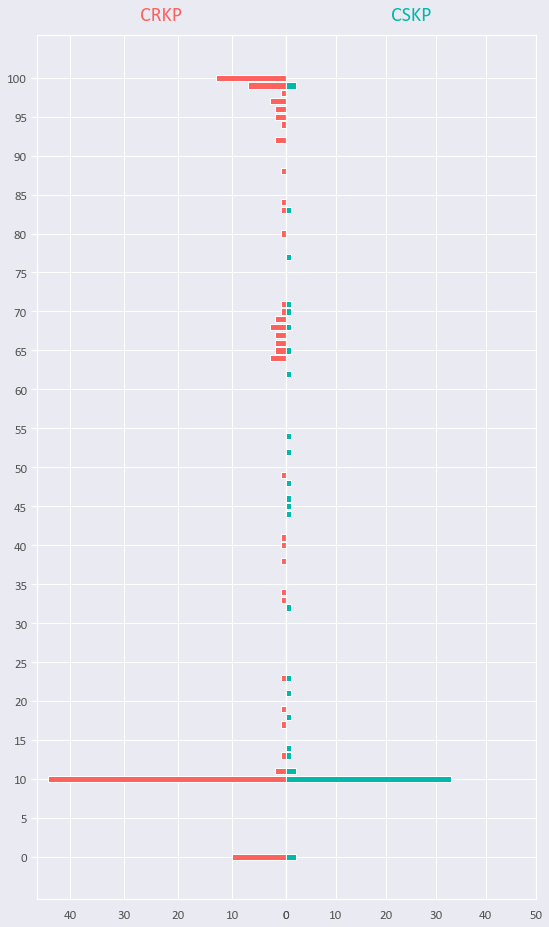

In [22]:
font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = BBC_KP.index
column0 = BBC_KP['Resist']
column1 = BBC_KP['Non_Resist']
title0 = 'CRKP'
title1 = 'CSKP'
fig, axes = plt.subplots(figsize=(9,16), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=20, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=20, pad=15, color=color_blue, **hfont)
axes[0].invert_xaxis() 
plt.gca()

axes[0].set(yticks=range(0, 105, 5), yticklabels=range(0, 105, 5))
axes[0].yaxis.tick_left()
# axes[0].set_yticks(range(0, 101))
axes[0].tick_params(axis='y', colors='white') # tick color
axes[1].set_xticks([0, 10, 20, 30, 40, 50])

axes[1].set_xticklabels([0, 10, 20, 30, 40, 50])


for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
    

# axes[0].axhline(y=85, color='blue', linestyle='--')
# axes[1].axhline(y=85, color='blue', linestyle='--')

# plt.annotate('Threshold=85%', xy=(25, 85), xytext=(25, 88), arrowprops = {'color':'blue'})

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)


In [23]:
SA.columns

Index(['病歷號碼', 'bed', '就醫序號', '申請編號', 'strain', '部位', 'Age', '抗藥性菌株',
       'examTime', 'reportTime', 'openTime', '菌株', 'PredValue', 'sendTime',
       'Group_Strain', 'PredLevel', 'Resist_bool', 'TH60', 'Resist', 'TH85',
       'Threshold', 'Non_Resist'],
      dtype='object')

In [24]:
fig = make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_yaxes=True, horizontal_spacing=0)
# bar plot for tv shows
fig.append_trace(go.Bar(x=df_tv_show.rating, y=df_tv_show.tv_show, orientation='h', showlegend=True, 
                        text=df_tv_show.rating_final, name='TV Show', marker_color='#221f1f'), 1, 1)
# bar plot for movies
fig.append_trace(go.Bar(x=df_movie.rating, y=df_movie.movie, orientation='h', showlegend=True, text=df_movie.rating,
                        name='Movie', marker_color='#b20710'), 1, 2)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, categoryorder='total ascending', ticksuffix=' ', showline=False)
fig.update_traces(hovertemplate=None, marker=dict(line=dict(width=0)))
fig.update_layout(title='Which has the highest rating TV shows or Movies?',
                  margin=dict(t=80, b=0, l=70, r=40),
                  hovermode="y unified", 
                  xaxis_title=' ', yaxis_title=" ",
                  plot_bgcolor='#333', paper_bgcolor='#333',
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  legend=dict(orientation="h", yanchor="bottom", y=1, xanchor="center", x=0.5),
                  hoverlabel=dict(bgcolor="black", font_size=13, font_family="Lato, sans-serif"))

NameError: name 'make_subplots' is not defined

In [25]:
position = CDSS.groupby(['Group_Strain', '部位', 'Resist_bool'])

In [26]:
PP = pd.DataFrame(position[['TH60']].value_counts(), columns=['Count'])

In [ ]:
# PP.to_excel(r'C:\Users\User\VSCode\CDSS_position.xlsx')

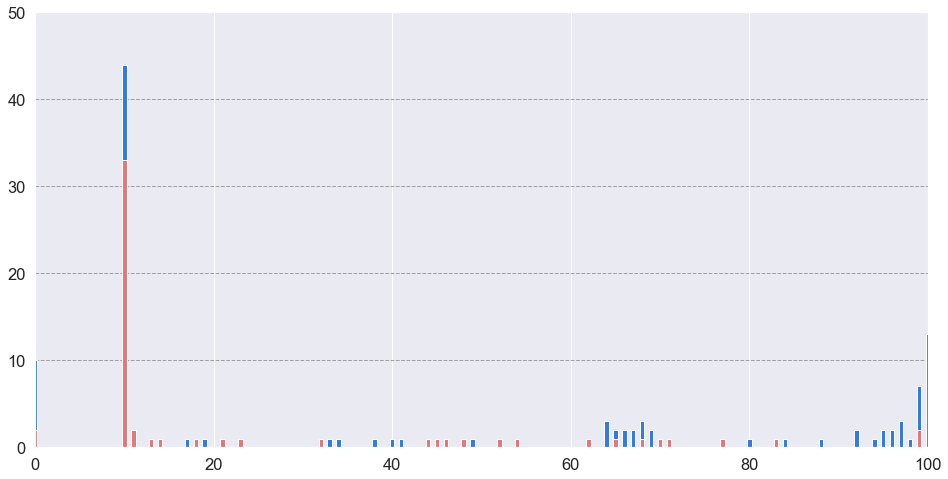

In [ ]:
fig, ax = plt.subplots(1, figsize=(16, 8))
plt.bar(index, column0, color = '#337AE3', width =0.5)
plt.bar(index, column1, color = '#E17979', width =0.5)

# x and y limits
plt.xlim(0, 100)
plt.ylim(0, 50)

ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

In [29]:
PP

Count
Group_Strain            部位    Resist_bool TH60        
Acinetobacter baumannii AS    True        False     13
                                          True       3
                        B     False       False      2
                                          True       1
                              True        False      4
...                                                ...
Staphylococcus aureus   SOFTT False       False      2
                                          True       1
                              True        True       3
                        UM    False       False      1
                              True        True       1

[191 rows x 1 columns]

In [32]:
PPP = pd.DataFrame(position[['TH60']].count())

In [33]:
PPPP = pd.merge(PP, PPP, how='left' , on=index)

KeyError: Int64Index([100,  99,  98,  97,  96,  95,  94,  92,  88,  84,  83,  80,  77,
             71,  70,  69,  68,  67,  66,  65,  64,  62,  54,  52,  49,  48,
             46,  45,  44,  41,  40,  38,  34,  33,  32,  23,  21,  19,  18,
             17,  14,  13,  11,  10,   0],
           dtype='int64', name='PredValue')

In [38]:
PPP.index 

MultiIndex([('Acinetobacter baumannii',    'AS',  True),
            ('Acinetobacter baumannii',     'B', False),
            ('Acinetobacter baumannii',     'B',  True),
            ('Acinetobacter baumannii',    'BF',  True),
            ('Acinetobacter baumannii',    'BI', False),
            ('Acinetobacter baumannii',    'BI',  True),
            ('Acinetobacter baumannii',    'CA', False),
            ('Acinetobacter baumannii',    'CA',  True),
            ('Acinetobacter baumannii',    'DP',  True),
            ('Acinetobacter baumannii',    'PF',  True),
            ...
            (  'Staphylococcus aureus',  'PUSS', False),
            (  'Staphylococcus aureus',  'PUSS',  True),
            (  'Staphylococcus aureus',   'SCO', False),
            (  'Staphylococcus aureus',   'SCO',  True),
            (  'Staphylococcus aureus',   'SET', False),
            (  'Staphylococcus aureus',   'SET',  True),
            (  'Staphylococcus aureus', 'SOFTT', False),
            (  

In [37]:
PP.index

MultiIndex([('Acinetobacter baumannii',    'AS',  True, False),
            ('Acinetobacter baumannii',    'AS',  True,  True),
            ('Acinetobacter baumannii',     'B', False, False),
            ('Acinetobacter baumannii',     'B', False,  True),
            ('Acinetobacter baumannii',     'B',  True, False),
            ('Acinetobacter baumannii',    'BF',  True,  True),
            ('Acinetobacter baumannii',    'BF',  True, False),
            ('Acinetobacter baumannii',    'BI', False, False),
            ('Acinetobacter baumannii',    'BI',  True, False),
            ('Acinetobacter baumannii',    'CA', False, False),
            ...
            (  'Staphylococcus aureus',   'SCO',  True,  True),
            (  'Staphylococcus aureus',   'SCO',  True, False),
            (  'Staphylococcus aureus',   'SET', False, False),
            (  'Staphylococcus aureus',   'SET',  True,  True),
            (  'Staphylococcus aureus',   'SET',  True, False),
            (  'Staphylo